# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size_and_log"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.001309,0.003672,-0.356520,0.721463,0.639268,random.pheno988
1,LV2,0.001019,0.002447,0.416609,0.676978,0.338489,random.pheno988
2,LV3,-0.010052,0.008174,-1.229719,0.218847,0.890576,random.pheno988
3,LV4,-0.008896,0.008554,-1.039976,0.298390,0.850805,random.pheno988
4,LV5,0.002354,0.012121,0.194227,0.846004,0.423002,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.045740628166160084

# QQ-plot

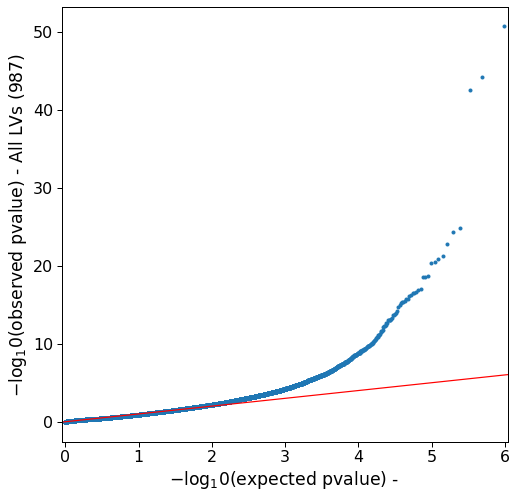

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.000,0.001,0.005
1,LV10,0.019,0.074,0.118
2,LV100,0.005,0.026,0.049
3,LV101,0.026,0.103,0.168
4,LV102,0.008,0.050,0.095


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.013511,0.045741,0.083408
std,0.018627,0.038874,0.057907
min,0.000000,0.000000,0.000000
25%,0.001000,0.009000,0.032000
50%,0.010000,0.045000,0.089000
75%,0.018000,0.067000,0.120000
max,0.230000,0.338000,0.392000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(38, 4)

,lv,1,5,10
942,LV948,0.006,0.049,0.109
256,LV33,0.014,0.049,0.091
486,LV537,0.015,0.049,0.089
491,LV541,0.020,0.049,0.089
144,LV229,0.012,0.049,0.085
518,LV566,0.014,0.049,0.091
332,LV399,0.011,0.049,0.098
119,LV206,0.012,0.049,0.084
655,LV69,0.009,0.049,0.087
84,LV175,0.019,0.049,0.085


,lv,1,5,10
4,LV102,0.008,0.050,0.095
130,LV216,0.011,0.050,0.101
37,LV132,0.014,0.050,0.088
53,LV147,0.015,0.050,0.088
214,LV292,0.009,0.050,0.090
99,LV189,0.006,0.050,0.093
177,LV259,0.013,0.050,0.093
117,LV204,0.014,0.050,0.100
12,LV11,0.009,0.051,0.085
792,LV812,0.019,0.051,0.092


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(310, 4)

,lv,1,5,10
743,LV769,0.056,0.143,0.203
734,LV760,0.081,0.143,0.233
153,LV237,0.076,0.149,0.219
436,LV492,0.063,0.161,0.230
383,LV444,0.070,0.161,0.233
466,LV519,0.085,0.163,0.228
289,LV36,0.104,0.174,0.226
549,LV594,0.106,0.177,0.236
349,LV413,0.101,0.179,0.229
815,LV833,0.092,0.179,0.255


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.010702,0.008596,1.245022,0.213169,0.106585,random.pheno988
1031,LV45,0.003012,0.008650,0.348236,0.727675,0.363837,random.pheno589
2018,LV45,0.001103,0.008575,0.128632,0.897653,0.448826,random.pheno385
3005,LV45,0.003858,0.008680,0.444420,0.656754,0.328377,random.pheno5
3992,LV45,-0.017968,0.008602,-2.088875,0.036758,0.981621,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.046

In [32]:
show_prop(results, 0.05)

0.106

In [33]:
show_prop(results, 0.10)

0.159

In [34]:
show_prop(results, 0.15)

0.207

In [35]:
show_prop(results, 0.20)

0.246

### QQplot

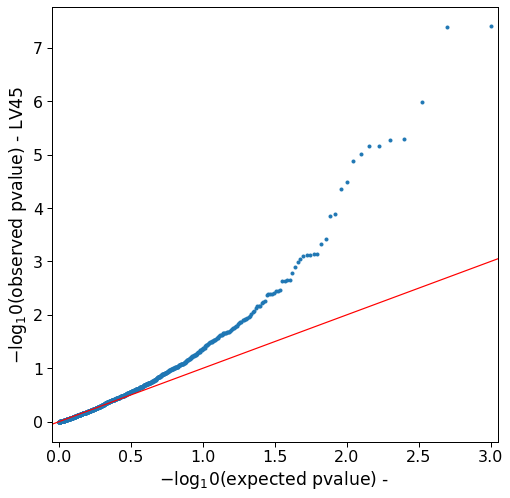

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.015929,0.010590,1.504176,0.132585,0.066293,random.pheno988
1220,LV234,0.003293,0.010658,0.308978,0.757348,0.378674,random.pheno589
2207,LV234,-0.004666,0.010565,-0.441701,0.658720,0.670640,random.pheno385
3194,LV234,0.004734,0.010695,0.442617,0.658057,0.329029,random.pheno5
4181,LV234,0.003793,0.010601,0.357784,0.720517,0.360258,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.016

In [43]:
show_prop(results, 0.05)

0.056

In [44]:
show_prop(results, 0.10)

0.1

In [45]:
show_prop(results, 0.15)

0.153

In [46]:
show_prop(results, 0.20)

0.198

### QQplot

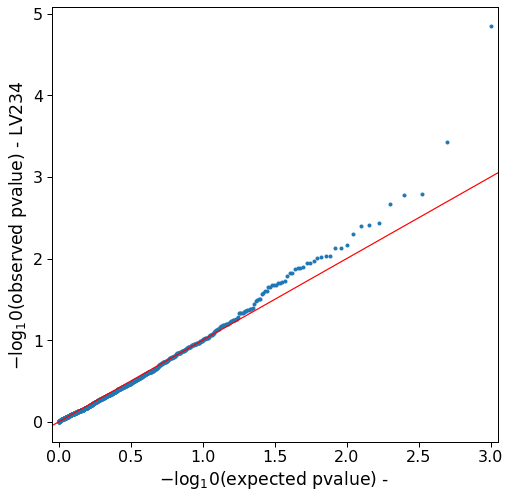

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.002064,0.010901,0.189370,0.849809,0.424904,random.pheno988
1833,LV847,-0.003097,0.010969,-0.282314,0.777712,0.611144,random.pheno589
2820,LV847,-0.013264,0.010872,-1.220012,0.222505,0.888747,random.pheno385
3807,LV847,-0.004022,0.011007,-0.365452,0.714786,0.642607,random.pheno5
4794,LV847,0.007033,0.010910,0.644597,0.519212,0.259606,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.008

In [54]:
show_prop(results, 0.05)

0.054

In [55]:
show_prop(results, 0.10)

0.092

In [56]:
show_prop(results, 0.15)

0.135

In [57]:
show_prop(results, 0.20)

0.17

### QQplot

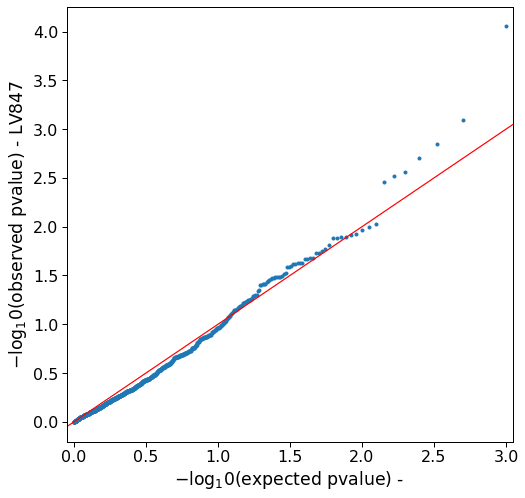

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.023292,0.008890,-2.620088,0.008811,0.995594,random.pheno988
1096,LV110,-0.013408,0.008949,-1.498315,0.134101,0.932950,random.pheno589
2083,LV110,-0.009060,0.008872,-1.021237,0.307180,0.846410,random.pheno385
3070,LV110,-0.008487,0.008981,-0.945031,0.344678,0.827661,random.pheno5
4057,LV110,0.008750,0.008902,0.982850,0.325718,0.162859,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.012

In [65]:
show_prop(results, 0.05)

0.042

In [66]:
show_prop(results, 0.10)

0.088

In [67]:
show_prop(results, 0.15)

0.133

In [68]:
show_prop(results, 0.20)

0.179

### QQplot

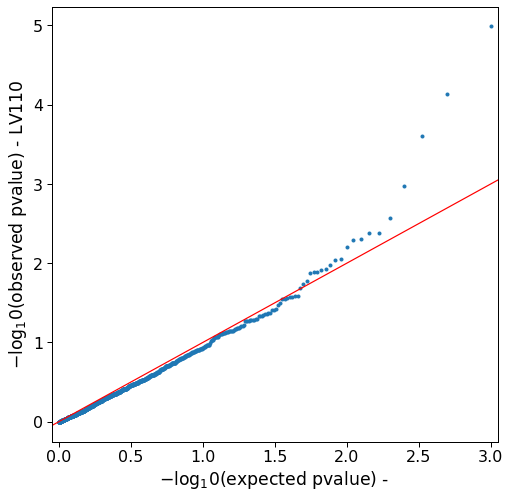

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014124,0.010239,1.379421,0.167813,0.083906,random.pheno988
1755,LV769,-0.007015,0.010304,-0.680807,0.496018,0.751991,random.pheno589
2742,LV769,-0.011280,0.010214,-1.104319,0.269496,0.865252,random.pheno385
3729,LV769,-0.014272,0.010339,-1.380408,0.167509,0.916246,random.pheno5
4716,LV769,-0.017737,0.010248,-1.730782,0.083539,0.958231,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.056

In [76]:
show_prop(results, 0.05)

0.143

In [77]:
show_prop(results, 0.10)

0.203

In [78]:
show_prop(results, 0.15)

0.254

In [79]:
show_prop(results, 0.20)

0.311

### QQplot

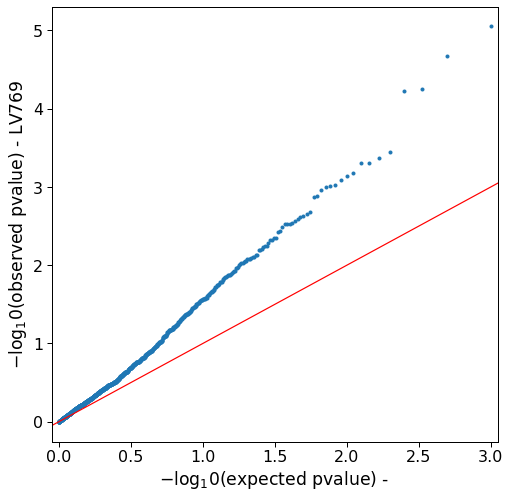

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.004603,0.012479,0.368869,0.712238,0.356119,random.pheno988
1786,LV800,-0.013071,0.012556,-1.041070,0.297882,0.851059,random.pheno589
2773,LV800,-0.004698,0.012447,-0.377467,0.705839,0.647080,random.pheno385
3760,LV800,-0.015677,0.012599,-1.244315,0.213429,0.893286,random.pheno5
4747,LV800,-0.009529,0.012490,-0.762955,0.445518,0.777241,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.01

In [87]:
show_prop(results, 0.05)

0.044

In [88]:
show_prop(results, 0.10)

0.1

In [89]:
show_prop(results, 0.15)

0.142

In [90]:
show_prop(results, 0.20)

0.19

### QQplot

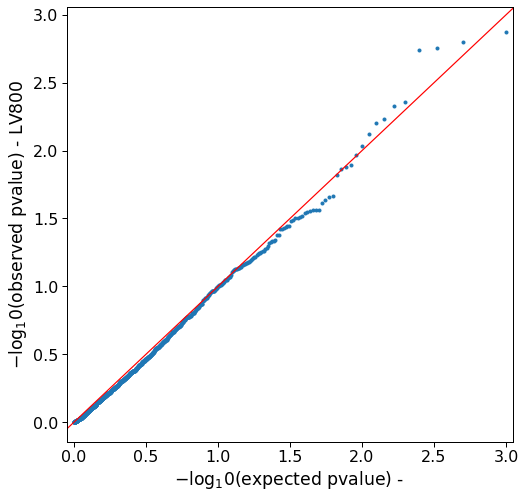

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
942,LV948,0.006,0.049,0.109
256,LV33,0.014,0.049,0.091
486,LV537,0.015,0.049,0.089
491,LV541,0.020,0.049,0.089
144,LV229,0.012,0.049,0.085
518,LV566,0.014,0.049,0.091
332,LV399,0.011,0.049,0.098
119,LV206,0.012,0.049,0.084
655,LV69,0.009,0.049,0.087
84,LV175,0.019,0.049,0.085


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.000074,0.006321,-0.011780,0.990601,0.504699,random.pheno988
1398,LV412,-0.003493,0.006361,-0.549165,0.582911,0.708544,random.pheno589
2385,LV412,0.002737,0.006305,0.434111,0.664223,0.332111,random.pheno385
3372,LV412,-0.002118,0.006383,-0.331893,0.739981,0.630009,random.pheno5
4359,LV412,0.005199,0.006327,0.821707,0.411274,0.205637,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.001

In [100]:
show_prop(results, 0.05)

0.009

In [101]:
show_prop(results, 0.10)

0.021

In [102]:
show_prop(results, 0.15)

0.06

In [103]:
show_prop(results, 0.20)

0.09

### QQplot

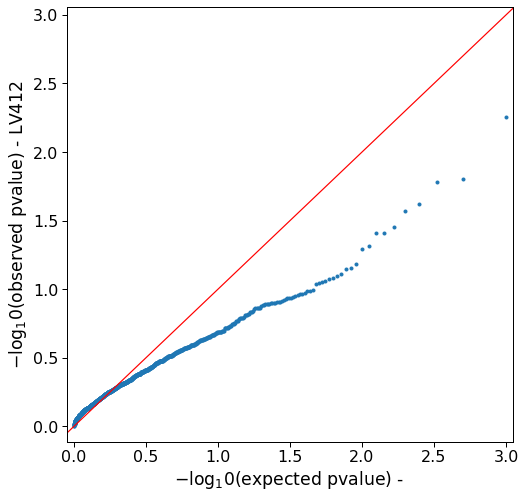

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.017088,0.009641,-1.772458,0.076366,0.961817,random.pheno988
1043,LV57,0.000598,0.009704,0.061648,0.950845,0.475423,random.pheno589
2030,LV57,0.019754,0.009616,2.054323,0.039985,0.019992,random.pheno385
3017,LV57,-0.004008,0.009737,-0.411596,0.680649,0.659675,random.pheno5
4004,LV57,-0.000862,0.009652,-0.089338,0.928816,0.535592,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.009

In [111]:
show_prop(results, 0.05)

0.053

In [112]:
show_prop(results, 0.10)

0.104

In [113]:
show_prop(results, 0.15)

0.15

In [114]:
show_prop(results, 0.20)

0.204

### QQplot

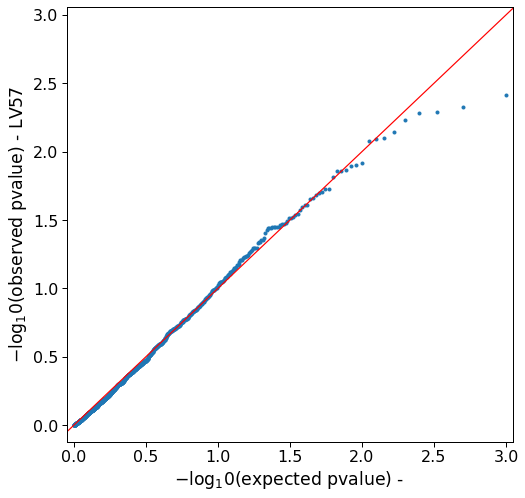

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007211,0.010781,-0.668877,0.503598,0.748201,random.pheno988
1633,LV647,0.008489,0.010848,0.782600,0.433891,0.216945,random.pheno589
2620,LV647,0.013600,0.010753,1.264798,0.205990,0.102995,random.pheno385
3607,LV647,-0.000179,0.010886,-0.016452,0.986874,0.506563,random.pheno5
4594,LV647,0.018936,0.010788,1.755260,0.079262,0.039631,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.023

In [122]:
show_prop(results, 0.05)

0.081

In [123]:
show_prop(results, 0.10)

0.12

In [124]:
show_prop(results, 0.15)

0.169

In [125]:
show_prop(results, 0.20)

0.217

### QQplot

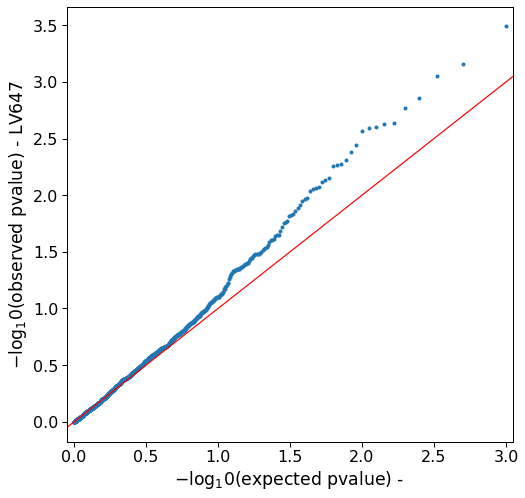

In [126]:
qqplot_unif(results)